In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

In [32]:

# Đọc và tiền xử lý dữ liệu
df_pre = pd.read_csv('C:/Users/vp322/Documents/Nam4/NCKH/DATA/Risk_2 - smooth.csv', sep=",", dtype=str)
df_pre = df_pre[['PM2.5_s', 'wd_s', 'ws_s', 'Rainfall_s', 'lowleaf_s', 'temp_s', 'uvb_s']]
values = df_pre.values.astype('float32')


In [33]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [34]:
# Chuyển đổi dữ liệu thành dạng học tập
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_hours = 18
n_features = 7
reframed = series_to_supervised(scaled, n_hours, 1)

In [35]:
# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
values = reframed.values
n_train_hours = 32469 - n_hours -1
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]


In [36]:
# Định hình lại đầu vào cho mô hình
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))


In [37]:
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def CNN_model(input_shape):
    inputs = Input(shape=input_shape)
    # Thêm nhiều lớp Conv1D để tăng cường khả năng trích xuất đặc trưng
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)  # Giảm chiều bằng cách lấy trung bình
    dense1 = Dense(64, activation='relu')(x)  # Lớp Dense
    dense2 = Dense(1)(dense1)  # Lớp đầu ra
    model = Model(inputs, dense2)
    return model

# Tạo mô hình với input shape tương ứng
model = CNN_model(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
model.compile(optimizer='adam', loss='mse')

'''
def CNN_model_v2(input_shape):
    inputs = Input(shape=input_shape)
    # Thêm lớp Conv1D với số lượng bộ lọc và kernel giống như mô hình ban đầu
    x = Conv1D(filters=7, kernel_size=1, activation='relu')(inputs)
    # Thêm một số lớp Conv1D để tăng cường khả năng trích xuất đặc trưng
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)  # Lớp pooling để giảm chiều
    dense1 = Dense(64, activation='relu')(x)  # Lớp Dense
    dense2 = Dense(1)(dense1)  # Lớp đầu ra
    model = Model(inputs, dense2)
    model.compile(optimizer='adam', loss='mse')
    return model

# Tạo mô hình với input shape tương ứng
model = CNN_model_v2(input_shape=(train_X.shape[1], train_X.shape[2]))
model.summary()
'''

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 18, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 18, 64)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 18, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,433 (134.50 KB)

 Trainable params: 34,433 (134.50 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as pyplot
history = model.fit(train_X, train_y, 
                    epochs=67, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, verbose=1,
                               mode='min', restore_best_weights=True)])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
'''
# Huấn luyện mô hình
history = model.fit(train_X, train_y, epochs=67 , batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False,)
'''

Epoch 1/67
1015/1015 - 3s - 3ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 2/67
1015/1015 - 2s - 2ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 3/67
1015/1015 - 2s - 2ms/step - loss: 9.2080e-04 - val_loss: 9.7701e-04
Epoch 4/67
1015/1015 - 3s - 3ms/step - loss: 7.7050e-04 - val_loss: 0.0016
Epoch 5/67
1015/1015 - 3s - 3ms/step - loss: 7.5164e-04 - val_loss: 0.0022
Epoch 6/67
1015/1015 - 2s - 2ms/step - loss: 7.7489e-04 - val_loss: 0.0039
Epoch 7/67
1015/1015 - 2s - 2ms/step - loss: 8.7497e-04 - val_loss: 0.0042
Epoch 8/67
1015/1015 - 3s - 2ms/step - loss: 9.3045e-04 - val_loss: 0.0074
Epoch 9/67
1015/1015 - 3s - 3ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 10/67
1015/1015 - 3s - 3ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 11/67
1015/1015 - 3s - 3ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 12/67
1015/1015 - 3s - 3ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 13/67
1015/1015 - 3s - 3ms/step - loss: 8.4890e-04 - val_loss: 0.0032
Epoch 14/67
1015/1015 - 3s - 3ms/step - l

In [39]:

# Dự đoán
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours * n_features))


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
# Đảo ngược chuẩn hóa cho dự đoán
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]


In [41]:

# Đảo ngược chuẩn hóa cho giá trị thực
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


In [42]:
# Tính toán RMSE, MAE và R²
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)

print('Test RMSE: %.4f' % rmse)
print('Test MAE: %.4f' % mae)
print('Test R2: %.4f' % r2)

Test RMSE: 4.5734
Test MAE: 3.4571
Test R2: 0.8645


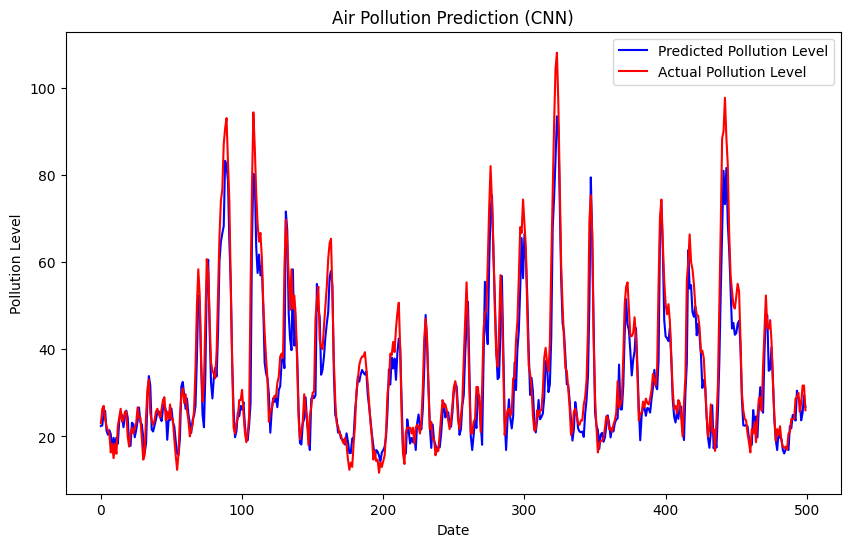

In [43]:

# Vẽ đồ thị so sánh giá trị thực và dự đoán
plt.figure(figsize=(10, 6))
plt.plot(inv_yhat[:500], color='blue', label='Predicted Pollution Level')
plt.plot(inv_y[:500], color='red', label='Actual Pollution Level')
plt.title("Air Pollution Prediction (CNN)")
plt.xlabel("Date")
plt.ylabel("Pollution Level")
plt.legend()
plt.show()

In [44]:
# Chuyển giá trị thực tế và giá trị dự đoán thành DataFrame
#df_results = pd.DataFrame({'Actual': inv_y, 'Predicted': inv_yhat})

In [45]:
# Lưu DataFrame vào file CSV
#df_results.to_csv('prediction_results_CNN.csv', index=False)